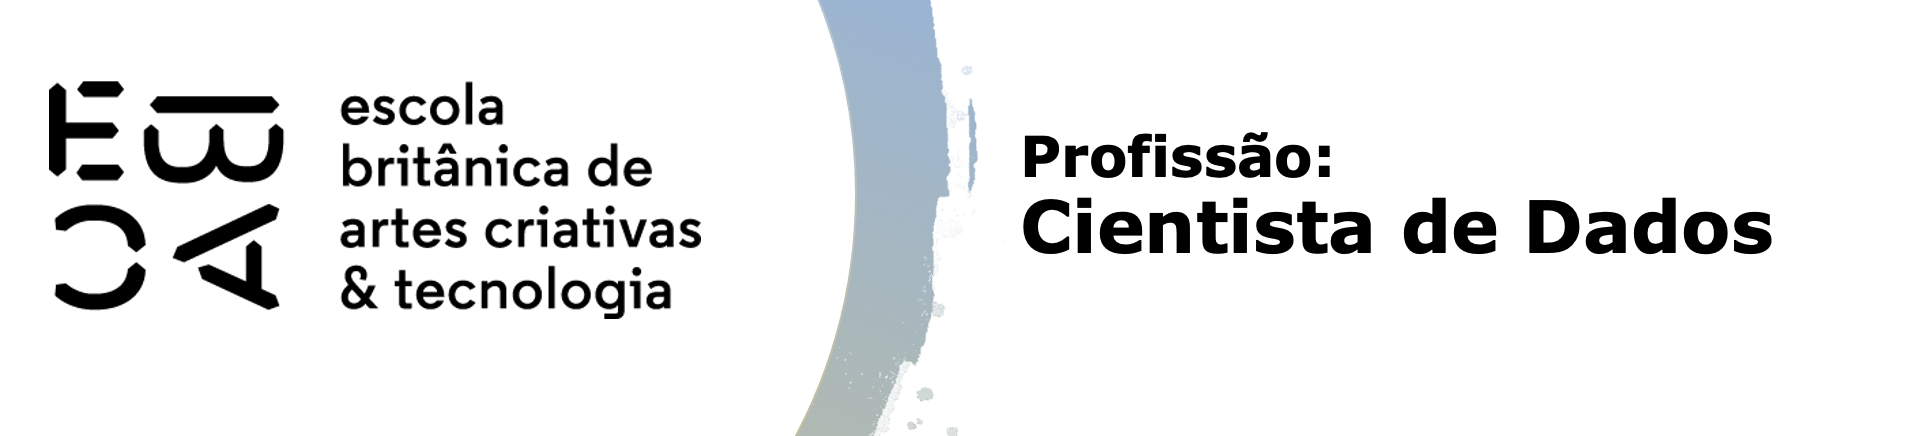

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics         import ConfusionMatrixDisplay

%matplotlib inline

In [2]:
%%time
# Carregando o banco de dados
X_train = pd.read_csv('https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/arquivos%20csv/X_train.csv', index_col=[0])
y_train = pd.read_csv('https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/arquivos%20csv/y_train.csv', index_col=[0])
X_test = pd.read_csv('https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/arquivos%20csv/X_test.csv', index_col=[0])
y_test = pd.read_csv('https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/arquivos%20csv/y_test.csv', index_col=[0])


CPU times: total: 906 ms
Wall time: 9.66 s


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [3]:
%%time
#Utilizando treinamento e teste, utilizando "min_samples_leaf=20" e separando as 3 melhores variáveis

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20).fit(X=X_train, y=y_train)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

three_best_vars = (pd.DataFrame(data={'var': X_train.columns, 'feature_importances_': clf.feature_importances_})
                     .sort_values(by='feature_importances_', ascending=False))

cols = three_best_vars['var'].values[:3]
X_train = X_train[cols]
X_test = X_test[cols]

print('3 melhores variáveis:', cols)

3 melhores variáveis: ["('tGravityAcc-min()-X',)" "('fBodyAcc-mad()-X',)"
 "('angle(Y,gravityMean)',)"]
CPU times: total: 3.62 s
Wall time: 8.82 s


In [4]:
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20).fit(X=X_train, y=y_train)
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

ccp_alphas.size

78

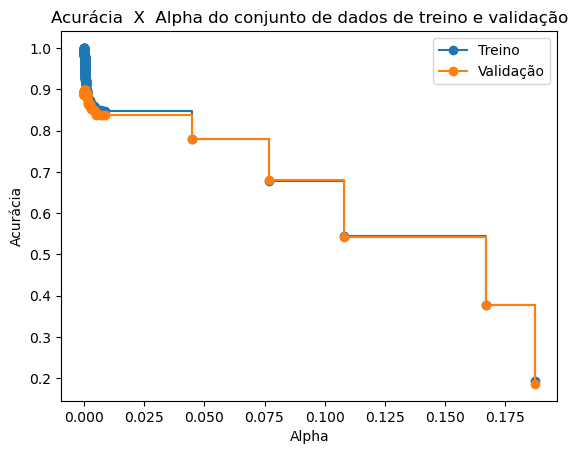

CPU times: total: 4.05 s
Wall time: 10.6 s


In [5]:
%%time

path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X=X_train, 
                                                                            y=y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X=X_train, y=y_train)
    clfs.append(clf)

train_scores = [clf.score(X=X_train, y=y_train) for clf in clfs]
valid_scores = [clf.score(X=X_valid[cols], y=y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel(xlabel='Alpha')
ax.set_ylabel(ylabel='Acurácia')
ax.set_title(label='Acurácia  X  Alpha do conjunto de dados de treino e validação')
ax.plot(ccp_alphas, train_scores,marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas, valid_scores, marker='o', label='Validação', drawstyle='steps-post')
ax.legend()
plt.show()

In [6]:
best_tree_index = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
best_tree = clfs[best_tree_index]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[best_tree_index] * 100:.2f}')

best_tree

Acurácia da melhor árvore na base de validação: 89.83


DecisionTreeClassifier(ccp_alpha=0.000346942959423444, random_state=42)

In [7]:
# Garantindo que os ccp_alphas são únicos e positivos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

ccp_alphas.size

214

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [8]:
%%time
# Utilizando cross validation do tipo k-fold com k=10
grid_parametros = {'ccp_alpha':ccp_alphas}
grid = GridSearchCV(estimator = clf, param_grid=grid_parametros,cv=10, verbose=100)
grid.fit(X_train, y_train) 

Fitting 10 folds for each of 214 candidates, totalling 2140 fits
[CV 1/10; 1/214] START ccp_alpha=0.0............................................
[CV 1/10; 1/214] END .............ccp_alpha=0.0;, score=0.895 total time=   0.0s
[CV 2/10; 1/214] START ccp_alpha=0.0............................................
[CV 2/10; 1/214] END .............ccp_alpha=0.0;, score=0.888 total time=   0.0s
[CV 3/10; 1/214] START ccp_alpha=0.0............................................
[CV 3/10; 1/214] END .............ccp_alpha=0.0;, score=0.873 total time=   0.0s
[CV 4/10; 1/214] START ccp_alpha=0.0............................................
[CV 4/10; 1/214] END .............ccp_alpha=0.0;, score=0.888 total time=   0.0s
[CV 5/10; 1/214] START ccp_alpha=0.0............................................
[CV 5/10; 1/214] END .............ccp_alpha=0.0;, score=0.878 total time=   0.0s
[CV 6/10; 1/214] START ccp_alpha=0.0............................................
[CV 6/10; 1/214] END .............ccp_alpha=

[CV 5/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.877 total time=   0.0s
[CV 6/10; 6/214] START ccp_alpha=0.00015113045580945474.........................
[CV 6/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.886 total time=   0.0s
[CV 7/10; 6/214] START ccp_alpha=0.00015113045580945474.........................
[CV 7/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.900 total time=   0.0s
[CV 8/10; 6/214] START ccp_alpha=0.00015113045580945474.........................
[CV 8/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.882 total time=   0.0s
[CV 9/10; 6/214] START ccp_alpha=0.00015113045580945474.........................
[CV 9/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.880 total time=   0.0s
[CV 10/10; 6/214] START ccp_alpha=0.00015113045580945474........................
[CV 10/10; 6/214] END ccp_alpha=0.00015113045580945474;, score=0.882 total time=   0.0s
[CV 1/10; 7/214] START ccp_alpha=0.0001534555397449848..................

[CV 4/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.893 total time=   0.0s
[CV 5/10; 11/214] START ccp_alpha=0.00016322089227421114........................
[CV 5/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.877 total time=   0.0s
[CV 6/10; 11/214] START ccp_alpha=0.00016322089227421114........................
[CV 6/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.886 total time=   0.0s
[CV 7/10; 11/214] START ccp_alpha=0.00016322089227421114........................
[CV 7/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.900 total time=   0.0s
[CV 8/10; 11/214] START ccp_alpha=0.00016322089227421114........................
[CV 8/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.880 total time=   0.0s
[CV 9/10; 11/214] START ccp_alpha=0.00016322089227421114........................
[CV 9/10; 11/214] END ccp_alpha=0.00016322089227421114;, score=0.880 total time=   0.0s
[CV 10/10; 11/214] START ccp_alpha=0.00016322089227421114..........

[CV 3/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.875 total time=   0.0s
[CV 4/10; 16/214] START ccp_alpha=0.00016926611050658926........................
[CV 4/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.893 total time=   0.0s
[CV 5/10; 16/214] START ccp_alpha=0.00016926611050658926........................
[CV 5/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.877 total time=   0.0s
[CV 6/10; 16/214] START ccp_alpha=0.00016926611050658926........................
[CV 6/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.886 total time=   0.0s
[CV 7/10; 16/214] START ccp_alpha=0.00016926611050658926........................
[CV 7/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.902 total time=   0.0s
[CV 8/10; 16/214] START ccp_alpha=0.00016926611050658926........................
[CV 8/10; 16/214] END ccp_alpha=0.00016926611050658926;, score=0.880 total time=   0.0s
[CV 9/10; 16/214] START ccp_alpha=0.00016926611050658926...........

[CV 2/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.889 total time=   0.0s
[CV 3/10; 21/214] START ccp_alpha=0.00017181146555180125........................
[CV 3/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.875 total time=   0.0s
[CV 4/10; 21/214] START ccp_alpha=0.00017181146555180125........................
[CV 4/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.893 total time=   0.0s
[CV 5/10; 21/214] START ccp_alpha=0.00017181146555180125........................
[CV 5/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.877 total time=   0.0s
[CV 6/10; 21/214] START ccp_alpha=0.00017181146555180125........................
[CV 6/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.886 total time=   0.0s
[CV 7/10; 21/214] START ccp_alpha=0.00017181146555180125........................
[CV 7/10; 21/214] END ccp_alpha=0.00017181146555180125;, score=0.902 total time=   0.0s
[CV 8/10; 21/214] START ccp_alpha=0.00017181146555180125...........

[CV 5/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.877 total time=   0.0s
[CV 6/10; 26/214] START ccp_alpha=0.00017311306756355715........................
[CV 6/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.889 total time=   0.0s
[CV 7/10; 26/214] START ccp_alpha=0.00017311306756355715........................
[CV 7/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.902 total time=   0.0s
[CV 8/10; 26/214] START ccp_alpha=0.00017311306756355715........................
[CV 8/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.880 total time=   0.0s
[CV 9/10; 26/214] START ccp_alpha=0.00017311306756355715........................
[CV 9/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.878 total time=   0.0s
[CV 10/10; 26/214] START ccp_alpha=0.00017311306756355715.......................
[CV 10/10; 26/214] END ccp_alpha=0.00017311306756355715;, score=0.880 total time=   0.0s
[CV 1/10; 27/214] START ccp_alpha=0.000173471479711722............

[CV 4/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.893 total time=   0.0s
[CV 5/10; 31/214] START ccp_alpha=0.00017586089403281993........................
[CV 5/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.877 total time=   0.0s
[CV 6/10; 31/214] START ccp_alpha=0.00017586089403281993........................
[CV 6/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.889 total time=   0.0s
[CV 7/10; 31/214] START ccp_alpha=0.00017586089403281993........................
[CV 7/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.902 total time=   0.0s
[CV 8/10; 31/214] START ccp_alpha=0.00017586089403281993........................
[CV 8/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.880 total time=   0.0s
[CV 9/10; 31/214] START ccp_alpha=0.00017586089403281993........................
[CV 9/10; 31/214] END ccp_alpha=0.00017586089403281993;, score=0.878 total time=   0.0s
[CV 10/10; 31/214] START ccp_alpha=0.00017586089403281993..........

[CV 3/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.875 total time=   0.0s
[CV 4/10; 36/214] START ccp_alpha=0.0001783834888242742.........................
[CV 4/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.893 total time=   0.0s
[CV 5/10; 36/214] START ccp_alpha=0.0001783834888242742.........................
[CV 5/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.877 total time=   0.0s
[CV 6/10; 36/214] START ccp_alpha=0.0001783834888242742.........................
[CV 6/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.891 total time=   0.0s
[CV 7/10; 36/214] START ccp_alpha=0.0001783834888242742.........................
[CV 7/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.902 total time=   0.0s
[CV 8/10; 36/214] START ccp_alpha=0.0001783834888242742.........................
[CV 8/10; 36/214] END ccp_alpha=0.0001783834888242742;, score=0.880 total time=   0.0s
[CV 9/10; 36/214] START ccp_alpha=0.0001783834888242742..................

[CV 8/10; 41/214] END ccp_alpha=0.00018099884175049602;, score=0.882 total time=   0.0s
[CV 9/10; 41/214] START ccp_alpha=0.00018099884175049602........................
[CV 9/10; 41/214] END ccp_alpha=0.00018099884175049602;, score=0.878 total time=   0.0s
[CV 10/10; 41/214] START ccp_alpha=0.00018099884175049602.......................
[CV 10/10; 41/214] END ccp_alpha=0.00018099884175049602;, score=0.884 total time=   0.0s
[CV 1/10; 42/214] START ccp_alpha=0.00018135654697134566........................
[CV 1/10; 42/214] END ccp_alpha=0.00018135654697134566;, score=0.893 total time=   0.0s
[CV 2/10; 42/214] START ccp_alpha=0.00018135654697134566........................
[CV 2/10; 42/214] END ccp_alpha=0.00018135654697134566;, score=0.891 total time=   0.0s
[CV 3/10; 42/214] START ccp_alpha=0.00018135654697134566........................
[CV 3/10; 42/214] END ccp_alpha=0.00018135654697134566;, score=0.875 total time=   0.0s
[CV 4/10; 42/214] START ccp_alpha=0.00018135654697134566..........

[CV 7/10; 46/214] END ccp_alpha=0.000185632932982414;, score=0.904 total time=   0.0s
[CV 8/10; 46/214] START ccp_alpha=0.000185632932982414..........................
[CV 8/10; 46/214] END ccp_alpha=0.000185632932982414;, score=0.882 total time=   0.0s
[CV 9/10; 46/214] START ccp_alpha=0.000185632932982414..........................
[CV 9/10; 46/214] END ccp_alpha=0.000185632932982414;, score=0.878 total time=   0.0s
[CV 10/10; 46/214] START ccp_alpha=0.000185632932982414.........................
[CV 10/10; 46/214] END ccp_alpha=0.000185632932982414;, score=0.882 total time=   0.0s
[CV 1/10; 47/214] START ccp_alpha=0.0001869290759732152.........................
[CV 1/10; 47/214] END ccp_alpha=0.0001869290759732152;, score=0.893 total time=   0.0s
[CV 2/10; 47/214] START ccp_alpha=0.0001869290759732152.........................
[CV 2/10; 47/214] END ccp_alpha=0.0001869290759732152;, score=0.893 total time=   0.0s
[CV 3/10; 47/214] START ccp_alpha=0.0001869290759732152.....................

[CV 6/10; 51/214] END ccp_alpha=0.00020956756538911058;, score=0.895 total time=   0.0s
[CV 7/10; 51/214] START ccp_alpha=0.00020956756538911058........................
[CV 7/10; 51/214] END ccp_alpha=0.00020956756538911058;, score=0.906 total time=   0.0s
[CV 8/10; 51/214] START ccp_alpha=0.00020956756538911058........................
[CV 8/10; 51/214] END ccp_alpha=0.00020956756538911058;, score=0.889 total time=   0.0s
[CV 9/10; 51/214] START ccp_alpha=0.00020956756538911058........................
[CV 9/10; 51/214] END ccp_alpha=0.00020956756538911058;, score=0.880 total time=   0.0s
[CV 10/10; 51/214] START ccp_alpha=0.00020956756538911058.......................
[CV 10/10; 51/214] END ccp_alpha=0.00020956756538911058;, score=0.887 total time=   0.0s
[CV 1/10; 52/214] START ccp_alpha=0.00021103307283938406........................
[CV 1/10; 52/214] END ccp_alpha=0.00021103307283938406;, score=0.906 total time=   0.0s
[CV 2/10; 52/214] START ccp_alpha=0.00021103307283938406..........

[CV 5/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.889 total time=   0.0s
[CV 6/10; 56/214] START ccp_alpha=0.00022669568371418212........................
[CV 6/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.893 total time=   0.0s
[CV 7/10; 56/214] START ccp_alpha=0.00022669568371418212........................
[CV 7/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.906 total time=   0.0s
[CV 8/10; 56/214] START ccp_alpha=0.00022669568371418212........................
[CV 8/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.889 total time=   0.0s
[CV 9/10; 56/214] START ccp_alpha=0.00022669568371418212........................
[CV 9/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.880 total time=   0.0s
[CV 10/10; 56/214] START ccp_alpha=0.00022669568371418212.......................
[CV 10/10; 56/214] END ccp_alpha=0.00022669568371418212;, score=0.889 total time=   0.0s
[CV 1/10; 57/214] START ccp_alpha=0.00023143151257234081..........

[CV 4/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.897 total time=   0.0s
[CV 5/10; 61/214] START ccp_alpha=0.00024114441959926201........................
[CV 5/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.889 total time=   0.0s
[CV 6/10; 61/214] START ccp_alpha=0.00024114441959926201........................
[CV 6/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.893 total time=   0.0s
[CV 7/10; 61/214] START ccp_alpha=0.00024114441959926201........................
[CV 7/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.906 total time=   0.0s
[CV 8/10; 61/214] START ccp_alpha=0.00024114441959926201........................
[CV 8/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.889 total time=   0.0s
[CV 9/10; 61/214] START ccp_alpha=0.00024114441959926201........................
[CV 9/10; 61/214] END ccp_alpha=0.00024114441959926201;, score=0.880 total time=   0.0s
[CV 10/10; 61/214] START ccp_alpha=0.00024114441959926201..........

[CV 8/10; 66/214] END ccp_alpha=0.00025537962736781327;, score=0.893 total time=   0.0s
[CV 9/10; 66/214] START ccp_alpha=0.00025537962736781327........................
[CV 9/10; 66/214] END ccp_alpha=0.00025537962736781327;, score=0.878 total time=   0.0s
[CV 10/10; 66/214] START ccp_alpha=0.00025537962736781327.......................
[CV 10/10; 66/214] END ccp_alpha=0.00025537962736781327;, score=0.889 total time=   0.0s
[CV 1/10; 67/214] START ccp_alpha=0.00025541047031797854........................
[CV 1/10; 67/214] END ccp_alpha=0.00025541047031797854;, score=0.906 total time=   0.0s
[CV 2/10; 67/214] START ccp_alpha=0.00025541047031797854........................
[CV 2/10; 67/214] END ccp_alpha=0.00025541047031797854;, score=0.897 total time=   0.0s
[CV 3/10; 67/214] START ccp_alpha=0.00025541047031797854........................
[CV 3/10; 67/214] END ccp_alpha=0.00025541047031797854;, score=0.875 total time=   0.0s
[CV 4/10; 67/214] START ccp_alpha=0.00025541047031797854..........

[CV 7/10; 71/214] END ccp_alpha=0.0002609240438639121;, score=0.906 total time=   0.0s
[CV 8/10; 71/214] START ccp_alpha=0.0002609240438639121.........................
[CV 8/10; 71/214] END ccp_alpha=0.0002609240438639121;, score=0.898 total time=   0.0s
[CV 9/10; 71/214] START ccp_alpha=0.0002609240438639121.........................
[CV 9/10; 71/214] END ccp_alpha=0.0002609240438639121;, score=0.878 total time=   0.0s
[CV 10/10; 71/214] START ccp_alpha=0.0002609240438639121........................
[CV 10/10; 71/214] END ccp_alpha=0.0002609240438639121;, score=0.891 total time=   0.0s
[CV 1/10; 72/214] START ccp_alpha=0.00026433013055300716........................
[CV 1/10; 72/214] END ccp_alpha=0.00026433013055300716;, score=0.906 total time=   0.0s
[CV 2/10; 72/214] START ccp_alpha=0.00026433013055300716........................
[CV 2/10; 72/214] END ccp_alpha=0.00026433013055300716;, score=0.899 total time=   0.0s
[CV 3/10; 72/214] START ccp_alpha=0.00026433013055300716..............

[CV 6/10; 76/214] END ccp_alpha=0.0002720348204570185;, score=0.895 total time=   0.0s
[CV 7/10; 76/214] START ccp_alpha=0.0002720348204570185.........................
[CV 7/10; 76/214] END ccp_alpha=0.0002720348204570185;, score=0.906 total time=   0.0s
[CV 8/10; 76/214] START ccp_alpha=0.0002720348204570185.........................
[CV 8/10; 76/214] END ccp_alpha=0.0002720348204570185;, score=0.902 total time=   0.0s
[CV 9/10; 76/214] START ccp_alpha=0.0002720348204570185.........................
[CV 9/10; 76/214] END ccp_alpha=0.0002720348204570185;, score=0.880 total time=   0.0s
[CV 10/10; 76/214] START ccp_alpha=0.0002720348204570185........................
[CV 10/10; 76/214] END ccp_alpha=0.0002720348204570185;, score=0.891 total time=   0.0s
[CV 1/10; 77/214] START ccp_alpha=0.0002788909825986183.........................
[CV 1/10; 77/214] END ccp_alpha=0.0002788909825986183;, score=0.904 total time=   0.0s
[CV 2/10; 77/214] START ccp_alpha=0.0002788909825986183.................

[CV 5/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.889 total time=   0.0s
[CV 6/10; 81/214] START ccp_alpha=0.000298761048431743..........................
[CV 6/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.889 total time=   0.0s
[CV 7/10; 81/214] START ccp_alpha=0.000298761048431743..........................
[CV 7/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.907 total time=   0.0s
[CV 8/10; 81/214] START ccp_alpha=0.000298761048431743..........................
[CV 8/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.902 total time=   0.0s
[CV 9/10; 81/214] START ccp_alpha=0.000298761048431743..........................
[CV 9/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.878 total time=   0.0s
[CV 10/10; 81/214] START ccp_alpha=0.000298761048431743.........................
[CV 10/10; 81/214] END ccp_alpha=0.000298761048431743;, score=0.895 total time=   0.0s
[CV 1/10; 82/214] START ccp_alpha=0.0003000384049158291.......................

[CV 10/10; 86/214] END ccp_alpha=0.00031089693766516406;, score=0.891 total time=   0.0s
[CV 1/10; 87/214] START ccp_alpha=0.00031379246812381583........................
[CV 1/10; 87/214] END ccp_alpha=0.00031379246812381583;, score=0.899 total time=   0.0s
[CV 2/10; 87/214] START ccp_alpha=0.00031379246812381583........................
[CV 2/10; 87/214] END ccp_alpha=0.00031379246812381583;, score=0.900 total time=   0.0s
[CV 3/10; 87/214] START ccp_alpha=0.00031379246812381583........................
[CV 3/10; 87/214] END ccp_alpha=0.00031379246812381583;, score=0.877 total time=   0.0s
[CV 4/10; 87/214] START ccp_alpha=0.00031379246812381583........................
[CV 4/10; 87/214] END ccp_alpha=0.00031379246812381583;, score=0.897 total time=   0.0s
[CV 5/10; 87/214] START ccp_alpha=0.00031379246812381583........................
[CV 5/10; 87/214] END ccp_alpha=0.00031379246812381583;, score=0.893 total time=   0.0s
[CV 6/10; 87/214] START ccp_alpha=0.00031379246812381583..........

[CV 5/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.897 total time=   0.0s
[CV 6/10; 92/214] START ccp_alpha=0.00032385097673454555........................
[CV 6/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.893 total time=   0.0s
[CV 7/10; 92/214] START ccp_alpha=0.00032385097673454555........................
[CV 7/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.911 total time=   0.0s
[CV 8/10; 92/214] START ccp_alpha=0.00032385097673454555........................
[CV 8/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.898 total time=   0.0s
[CV 9/10; 92/214] START ccp_alpha=0.00032385097673454555........................
[CV 9/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.878 total time=   0.0s
[CV 10/10; 92/214] START ccp_alpha=0.00032385097673454555.......................
[CV 10/10; 92/214] END ccp_alpha=0.00032385097673454555;, score=0.889 total time=   0.0s
[CV 1/10; 93/214] START ccp_alpha=0.0003264417845484223...........

[CV 4/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.895 total time=   0.0s
[CV 5/10; 97/214] START ccp_alpha=0.0003360141809863374.........................
[CV 5/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.895 total time=   0.0s
[CV 6/10; 97/214] START ccp_alpha=0.0003360141809863374.........................
[CV 6/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.898 total time=   0.0s
[CV 7/10; 97/214] START ccp_alpha=0.0003360141809863374.........................
[CV 7/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.913 total time=   0.0s
[CV 8/10; 97/214] START ccp_alpha=0.0003360141809863374.........................
[CV 8/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.900 total time=   0.0s
[CV 9/10; 97/214] START ccp_alpha=0.0003360141809863374.........................
[CV 9/10; 97/214] END ccp_alpha=0.0003360141809863374;, score=0.882 total time=   0.0s
[CV 10/10; 97/214] START ccp_alpha=0.0003360141809863374.................

[CV 3/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.875 total time=   0.0s
[CV 4/10; 102/214] START ccp_alpha=0.00034149141874930777.......................
[CV 4/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.895 total time=   0.0s
[CV 5/10; 102/214] START ccp_alpha=0.00034149141874930777.......................
[CV 5/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.895 total time=   0.0s
[CV 6/10; 102/214] START ccp_alpha=0.00034149141874930777.......................
[CV 6/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.898 total time=   0.0s
[CV 7/10; 102/214] START ccp_alpha=0.00034149141874930777.......................
[CV 7/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.913 total time=   0.0s
[CV 8/10; 102/214] START ccp_alpha=0.00034149141874930777.......................
[CV 8/10; 102/214] END ccp_alpha=0.00034149141874930777;, score=0.900 total time=   0.0s
[CV 9/10; 102/214] START ccp_alpha=0.00034149141874930777....

[CV 2/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.899 total time=   0.0s
[CV 3/10; 107/214] START ccp_alpha=0.0003526377302220609........................
[CV 3/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.875 total time=   0.0s
[CV 4/10; 107/214] START ccp_alpha=0.0003526377302220609........................
[CV 4/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.895 total time=   0.0s
[CV 5/10; 107/214] START ccp_alpha=0.0003526377302220609........................
[CV 5/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.893 total time=   0.0s
[CV 6/10; 107/214] START ccp_alpha=0.0003526377302220609........................
[CV 6/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.900 total time=   0.0s
[CV 7/10; 107/214] START ccp_alpha=0.0003526377302220609........................
[CV 7/10; 107/214] END ccp_alpha=0.0003526377302220609;, score=0.913 total time=   0.0s
[CV 8/10; 107/214] START ccp_alpha=0.0003526377302220609...........

[CV 1/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.893 total time=   0.0s
[CV 2/10; 112/214] START ccp_alpha=0.00036530390175656794.......................
[CV 2/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.895 total time=   0.0s
[CV 3/10; 112/214] START ccp_alpha=0.00036530390175656794.......................
[CV 3/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.879 total time=   0.0s
[CV 4/10; 112/214] START ccp_alpha=0.00036530390175656794.......................
[CV 4/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.895 total time=   0.0s
[CV 5/10; 112/214] START ccp_alpha=0.00036530390175656794.......................
[CV 5/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.895 total time=   0.0s
[CV 6/10; 112/214] START ccp_alpha=0.00036530390175656794.......................
[CV 6/10; 112/214] END ccp_alpha=0.00036530390175656794;, score=0.898 total time=   0.0s
[CV 7/10; 112/214] START ccp_alpha=0.00036530390175656794....

[CV 5/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.898 total time=   0.0s
[CV 6/10; 117/214] START ccp_alpha=0.0004019119098407388........................
[CV 6/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.897 total time=   0.0s
[CV 7/10; 117/214] START ccp_alpha=0.0004019119098407388........................
[CV 7/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.906 total time=   0.0s
[CV 8/10; 117/214] START ccp_alpha=0.0004019119098407388........................
[CV 8/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.902 total time=   0.0s
[CV 9/10; 117/214] START ccp_alpha=0.0004019119098407388........................
[CV 9/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.884 total time=   0.0s
[CV 10/10; 117/214] START ccp_alpha=0.0004019119098407388.......................
[CV 10/10; 117/214] END ccp_alpha=0.0004019119098407388;, score=0.900 total time=   0.0s
[CV 1/10; 118/214] START ccp_alpha=0.0004098323443547457..........

[CV 7/10; 122/214] END ccp_alpha=0.00042244726184040553;, score=0.906 total time=   0.0s
[CV 8/10; 122/214] START ccp_alpha=0.00042244726184040553.......................
[CV 8/10; 122/214] END ccp_alpha=0.00042244726184040553;, score=0.895 total time=   0.0s
[CV 9/10; 122/214] START ccp_alpha=0.00042244726184040553.......................
[CV 9/10; 122/214] END ccp_alpha=0.00042244726184040553;, score=0.886 total time=   0.0s
[CV 10/10; 122/214] START ccp_alpha=0.00042244726184040553......................
[CV 10/10; 122/214] END ccp_alpha=0.00042244726184040553;, score=0.902 total time=   0.0s
[CV 1/10; 123/214] START ccp_alpha=0.0004276196475955941........................
[CV 1/10; 123/214] END ccp_alpha=0.0004276196475955941;, score=0.897 total time=   0.0s
[CV 2/10; 123/214] START ccp_alpha=0.0004276196475955941........................
[CV 2/10; 123/214] END ccp_alpha=0.0004276196475955941;, score=0.895 total time=   0.0s
[CV 3/10; 123/214] START ccp_alpha=0.0004276196475955941......

[CV 10/10; 127/214] END ccp_alpha=0.0004517380468739272;, score=0.906 total time=   0.0s
[CV 1/10; 128/214] START ccp_alpha=0.00045408419546975984.......................
[CV 1/10; 128/214] END ccp_alpha=0.00045408419546975984;, score=0.899 total time=   0.0s
[CV 2/10; 128/214] START ccp_alpha=0.00045408419546975984.......................
[CV 2/10; 128/214] END ccp_alpha=0.00045408419546975984;, score=0.895 total time=   0.0s
[CV 3/10; 128/214] START ccp_alpha=0.00045408419546975984.......................
[CV 3/10; 128/214] END ccp_alpha=0.00045408419546975984;, score=0.886 total time=   0.0s
[CV 4/10; 128/214] START ccp_alpha=0.00045408419546975984.......................
[CV 4/10; 128/214] END ccp_alpha=0.00045408419546975984;, score=0.897 total time=   0.0s
[CV 5/10; 128/214] START ccp_alpha=0.00045408419546975984.......................
[CV 5/10; 128/214] END ccp_alpha=0.00045408419546975984;, score=0.898 total time=   0.0s
[CV 6/10; 128/214] START ccp_alpha=0.00045408419546975984....

[CV 5/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.893 total time=   0.0s
[CV 6/10; 133/214] START ccp_alpha=0.00046896238408752005.......................
[CV 6/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.895 total time=   0.0s
[CV 7/10; 133/214] START ccp_alpha=0.00046896238408752005.......................
[CV 7/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.898 total time=   0.0s
[CV 8/10; 133/214] START ccp_alpha=0.00046896238408752005.......................
[CV 8/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.895 total time=   0.0s
[CV 9/10; 133/214] START ccp_alpha=0.00046896238408752005.......................
[CV 9/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.889 total time=   0.0s
[CV 10/10; 133/214] START ccp_alpha=0.00046896238408752005......................
[CV 10/10; 133/214] END ccp_alpha=0.00046896238408752005;, score=0.907 total time=   0.0s
[CV 1/10; 134/214] START ccp_alpha=0.00047105596615933944...

[CV 4/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.897 total time=   0.0s
[CV 5/10; 138/214] START ccp_alpha=0.0005036530390175652........................
[CV 5/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.893 total time=   0.0s
[CV 6/10; 138/214] START ccp_alpha=0.0005036530390175652........................
[CV 6/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.900 total time=   0.0s
[CV 7/10; 138/214] START ccp_alpha=0.0005036530390175652........................
[CV 7/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.895 total time=   0.0s
[CV 8/10; 138/214] START ccp_alpha=0.0005036530390175652........................
[CV 8/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.897 total time=   0.0s
[CV 9/10; 138/214] START ccp_alpha=0.0005036530390175652........................
[CV 9/10; 138/214] END ccp_alpha=0.0005036530390175652;, score=0.889 total time=   0.0s
[CV 10/10; 138/214] START ccp_alpha=0.0005036530390175652..........

[CV 3/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.884 total time=   0.0s
[CV 4/10; 143/214] START ccp_alpha=0.0005494458231365081........................
[CV 4/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.897 total time=   0.0s
[CV 5/10; 143/214] START ccp_alpha=0.0005494458231365081........................
[CV 5/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.889 total time=   0.0s
[CV 6/10; 143/214] START ccp_alpha=0.0005494458231365081........................
[CV 6/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.902 total time=   0.0s
[CV 7/10; 143/214] START ccp_alpha=0.0005494458231365081........................
[CV 7/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.895 total time=   0.0s
[CV 8/10; 143/214] START ccp_alpha=0.0005494458231365081........................
[CV 8/10; 143/214] END ccp_alpha=0.0005494458231365081;, score=0.891 total time=   0.0s
[CV 9/10; 143/214] START ccp_alpha=0.0005494458231365081...........

[CV 7/10; 148/214] END ccp_alpha=0.0005803409503083059;, score=0.895 total time=   0.0s
[CV 8/10; 148/214] START ccp_alpha=0.0005803409503083059........................
[CV 8/10; 148/214] END ccp_alpha=0.0005803409503083059;, score=0.889 total time=   0.0s
[CV 9/10; 148/214] START ccp_alpha=0.0005803409503083059........................
[CV 9/10; 148/214] END ccp_alpha=0.0005803409503083059;, score=0.887 total time=   0.0s
[CV 10/10; 148/214] START ccp_alpha=0.0005803409503083059.......................
[CV 10/10; 148/214] END ccp_alpha=0.0005803409503083059;, score=0.906 total time=   0.0s
[CV 1/10; 149/214] START ccp_alpha=0.0005836994048818495........................
[CV 1/10; 149/214] END ccp_alpha=0.0005836994048818495;, score=0.904 total time=   0.0s
[CV 2/10; 149/214] START ccp_alpha=0.0005836994048818495........................
[CV 2/10; 149/214] END ccp_alpha=0.0005836994048818495;, score=0.891 total time=   0.0s
[CV 3/10; 149/214] START ccp_alpha=0.0005836994048818495..........

[CV 2/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.888 total time=   0.0s
[CV 3/10; 154/214] START ccp_alpha=0.0006148342543401111........................
[CV 3/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.884 total time=   0.0s
[CV 4/10; 154/214] START ccp_alpha=0.0006148342543401111........................
[CV 4/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.897 total time=   0.0s
[CV 5/10; 154/214] START ccp_alpha=0.0006148342543401111........................
[CV 5/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.893 total time=   0.0s
[CV 6/10; 154/214] START ccp_alpha=0.0006148342543401111........................
[CV 6/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.904 total time=   0.0s
[CV 7/10; 154/214] START ccp_alpha=0.0006148342543401111........................
[CV 7/10; 154/214] END ccp_alpha=0.0006148342543401111;, score=0.895 total time=   0.0s
[CV 8/10; 154/214] START ccp_alpha=0.0006148342543401111...........

[CV 1/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.906 total time=   0.0s
[CV 2/10; 159/214] START ccp_alpha=0.0006896586466771455........................
[CV 2/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.888 total time=   0.0s
[CV 3/10; 159/214] START ccp_alpha=0.0006896586466771455........................
[CV 3/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.882 total time=   0.0s
[CV 4/10; 159/214] START ccp_alpha=0.0006896586466771455........................
[CV 4/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.895 total time=   0.0s
[CV 5/10; 159/214] START ccp_alpha=0.0006896586466771455........................
[CV 5/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.886 total time=   0.0s
[CV 6/10; 159/214] START ccp_alpha=0.0006896586466771455........................
[CV 6/10; 159/214] END ccp_alpha=0.0006896586466771455;, score=0.898 total time=   0.0s
[CV 7/10; 159/214] START ccp_alpha=0.0006896586466771455...........

[CV 5/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.886 total time=   0.0s
[CV 6/10; 164/214] START ccp_alpha=0.0007334127957567757........................
[CV 6/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.898 total time=   0.0s
[CV 7/10; 164/214] START ccp_alpha=0.0007334127957567757........................
[CV 7/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.882 total time=   0.0s
[CV 8/10; 164/214] START ccp_alpha=0.0007334127957567757........................
[CV 8/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.882 total time=   0.0s
[CV 9/10; 164/214] START ccp_alpha=0.0007334127957567757........................
[CV 9/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.884 total time=   0.0s
[CV 10/10; 164/214] START ccp_alpha=0.0007334127957567757.......................
[CV 10/10; 164/214] END ccp_alpha=0.0007334127957567757;, score=0.891 total time=   0.0s
[CV 1/10; 165/214] START ccp_alpha=0.0007480957562568009..........

[CV 4/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.895 total time=   0.0s
[CV 5/10; 169/214] START ccp_alpha=0.000797968806673921.........................
[CV 5/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.882 total time=   0.0s
[CV 6/10; 169/214] START ccp_alpha=0.000797968806673921.........................
[CV 6/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.904 total time=   0.0s
[CV 7/10; 169/214] START ccp_alpha=0.000797968806673921.........................
[CV 7/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.882 total time=   0.0s
[CV 8/10; 169/214] START ccp_alpha=0.000797968806673921.........................
[CV 8/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.887 total time=   0.0s
[CV 9/10; 169/214] START ccp_alpha=0.000797968806673921.........................
[CV 9/10; 169/214] END ccp_alpha=0.000797968806673921;, score=0.880 total time=   0.0s
[CV 10/10; 169/214] START ccp_alpha=0.000797968806673921.................

[CV 3/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.864 total time=   0.0s
[CV 4/10; 174/214] START ccp_alpha=0.0008651370848673572........................
[CV 4/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.893 total time=   0.0s
[CV 5/10; 174/214] START ccp_alpha=0.0008651370848673572........................
[CV 5/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.880 total time=   0.0s
[CV 6/10; 174/214] START ccp_alpha=0.0008651370848673572........................
[CV 6/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.902 total time=   0.0s
[CV 7/10; 174/214] START ccp_alpha=0.0008651370848673572........................
[CV 7/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.887 total time=   0.0s
[CV 8/10; 174/214] START ccp_alpha=0.0008651370848673572........................
[CV 8/10; 174/214] END ccp_alpha=0.0008651370848673572;, score=0.886 total time=   0.0s
[CV 9/10; 174/214] START ccp_alpha=0.0008651370848673572...........

[CV 2/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.873 total time=   0.0s
[CV 3/10; 179/214] START ccp_alpha=0.0010332387916718727........................
[CV 3/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.857 total time=   0.0s
[CV 4/10; 179/214] START ccp_alpha=0.0010332387916718727........................
[CV 4/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.889 total time=   0.0s
[CV 5/10; 179/214] START ccp_alpha=0.0010332387916718727........................
[CV 5/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.875 total time=   0.0s
[CV 6/10; 179/214] START ccp_alpha=0.0010332387916718727........................
[CV 6/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.889 total time=   0.0s
[CV 7/10; 179/214] START ccp_alpha=0.0010332387916718727........................
[CV 7/10; 179/214] END ccp_alpha=0.0010332387916718727;, score=0.869 total time=   0.0s
[CV 8/10; 179/214] START ccp_alpha=0.0010332387916718727...........

[CV 1/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.900 total time=   0.0s
[CV 2/10; 184/214] START ccp_alpha=0.0011358916953453746........................
[CV 2/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.871 total time=   0.0s
[CV 3/10; 184/214] START ccp_alpha=0.0011358916953453746........................
[CV 3/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.850 total time=   0.0s
[CV 4/10; 184/214] START ccp_alpha=0.0011358916953453746........................
[CV 4/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.889 total time=   0.0s
[CV 5/10; 184/214] START ccp_alpha=0.0011358916953453746........................
[CV 5/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.871 total time=   0.0s
[CV 6/10; 184/214] START ccp_alpha=0.0011358916953453746........................
[CV 6/10; 184/214] END ccp_alpha=0.0011358916953453746;, score=0.878 total time=   0.0s
[CV 7/10; 184/214] START ccp_alpha=0.0011358916953453746...........

[CV 10/10; 188/214] END ccp_alpha=0.0012832117400769787;, score=0.875 total time=   0.0s
[CV 1/10; 189/214] START ccp_alpha=0.001288229362222833.........................
[CV 1/10; 189/214] END ccp_alpha=0.001288229362222833;, score=0.895 total time=   0.0s
[CV 2/10; 189/214] START ccp_alpha=0.001288229362222833.........................
[CV 2/10; 189/214] END ccp_alpha=0.001288229362222833;, score=0.862 total time=   0.0s
[CV 3/10; 189/214] START ccp_alpha=0.001288229362222833.........................
[CV 3/10; 189/214] END ccp_alpha=0.001288229362222833;, score=0.842 total time=   0.0s
[CV 4/10; 189/214] START ccp_alpha=0.001288229362222833.........................
[CV 4/10; 189/214] END ccp_alpha=0.001288229362222833;, score=0.886 total time=   0.0s
[CV 5/10; 189/214] START ccp_alpha=0.001288229362222833.........................
[CV 5/10; 189/214] END ccp_alpha=0.001288229362222833;, score=0.871 total time=   0.0s
[CV 6/10; 189/214] START ccp_alpha=0.001288229362222833................

[CV 9/10; 193/214] END ccp_alpha=0.0016139412448806737;, score=0.868 total time=   0.0s
[CV 10/10; 193/214] START ccp_alpha=0.0016139412448806737.......................
[CV 10/10; 193/214] END ccp_alpha=0.0016139412448806737;, score=0.875 total time=   0.0s
[CV 1/10; 194/214] START ccp_alpha=0.0018211219925039282........................
[CV 1/10; 194/214] END ccp_alpha=0.0018211219925039282;, score=0.882 total time=   0.0s
[CV 2/10; 194/214] START ccp_alpha=0.0018211219925039282........................
[CV 2/10; 194/214] END ccp_alpha=0.0018211219925039282;, score=0.866 total time=   0.0s
[CV 3/10; 194/214] START ccp_alpha=0.0018211219925039282........................
[CV 3/10; 194/214] END ccp_alpha=0.0018211219925039282;, score=0.839 total time=   0.0s
[CV 4/10; 194/214] START ccp_alpha=0.0018211219925039282........................
[CV 4/10; 194/214] END ccp_alpha=0.0018211219925039282;, score=0.877 total time=   0.0s
[CV 5/10; 194/214] START ccp_alpha=0.0018211219925039282..........

[CV 8/10; 198/214] END ccp_alpha=0.002311780517449114;, score=0.855 total time=   0.0s
[CV 9/10; 198/214] START ccp_alpha=0.002311780517449114.........................
[CV 9/10; 198/214] END ccp_alpha=0.002311780517449114;, score=0.875 total time=   0.0s
[CV 10/10; 198/214] START ccp_alpha=0.002311780517449114........................
[CV 10/10; 198/214] END ccp_alpha=0.002311780517449114;, score=0.862 total time=   0.0s
[CV 1/10; 199/214] START ccp_alpha=0.002352703485227396.........................
[CV 1/10; 199/214] END ccp_alpha=0.002352703485227396;, score=0.875 total time=   0.0s
[CV 2/10; 199/214] START ccp_alpha=0.002352703485227396.........................
[CV 2/10; 199/214] END ccp_alpha=0.002352703485227396;, score=0.862 total time=   0.0s
[CV 3/10; 199/214] START ccp_alpha=0.002352703485227396.........................
[CV 3/10; 199/214] END ccp_alpha=0.002352703485227396;, score=0.835 total time=   0.0s
[CV 4/10; 199/214] START ccp_alpha=0.002352703485227396.................

[CV 7/10; 203/214] END ccp_alpha=0.004197165683128001;, score=0.844 total time=   0.0s
[CV 8/10; 203/214] START ccp_alpha=0.004197165683128001.........................
[CV 8/10; 203/214] END ccp_alpha=0.004197165683128001;, score=0.858 total time=   0.0s
[CV 9/10; 203/214] START ccp_alpha=0.004197165683128001.........................
[CV 9/10; 203/214] END ccp_alpha=0.004197165683128001;, score=0.866 total time=   0.0s
[CV 10/10; 203/214] START ccp_alpha=0.004197165683128001........................
[CV 10/10; 203/214] END ccp_alpha=0.004197165683128001;, score=0.851 total time=   0.0s
[CV 1/10; 204/214] START ccp_alpha=0.004272771638898935.........................
[CV 1/10; 204/214] END ccp_alpha=0.004272771638898935;, score=0.855 total time=   0.0s
[CV 2/10; 204/214] START ccp_alpha=0.004272771638898935.........................
[CV 2/10; 204/214] END ccp_alpha=0.004272771638898935;, score=0.857 total time=   0.0s
[CV 3/10; 204/214] START ccp_alpha=0.004272771638898935.................

[CV 2/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.861 total time=   0.0s
[CV 3/10; 209/214] START ccp_alpha=0.008605541777454748.........................
[CV 3/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.817 total time=   0.0s
[CV 4/10; 209/214] START ccp_alpha=0.008605541777454748.........................
[CV 4/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.853 total time=   0.0s
[CV 5/10; 209/214] START ccp_alpha=0.008605541777454748.........................
[CV 5/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.842 total time=   0.0s
[CV 6/10; 209/214] START ccp_alpha=0.008605541777454748.........................
[CV 6/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.842 total time=   0.0s
[CV 7/10; 209/214] START ccp_alpha=0.008605541777454748.........................
[CV 7/10; 209/214] END ccp_alpha=0.008605541777454748;, score=0.844 total time=   0.0s
[CV 8/10; 209/214] START ccp_alpha=0.008605541777454748..................

[CV 4/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.194 total time=   0.0s
[CV 5/10; 214/214] START ccp_alpha=0.18729938595805384..........................
[CV 5/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.379 total time=   0.0s
[CV 6/10; 214/214] START ccp_alpha=0.18729938595805384..........................
[CV 6/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.379 total time=   0.0s
[CV 7/10; 214/214] START ccp_alpha=0.18729938595805384..........................
[CV 7/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.377 total time=   0.0s
[CV 8/10; 214/214] START ccp_alpha=0.18729938595805384..........................
[CV 8/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.377 total time=   0.0s
[CV 9/10; 214/214] START ccp_alpha=0.18729938595805384..........................
[CV 9/10; 214/214] END ccp_alpha=0.18729938595805384;, score=0.377 total time=   0.0s
[CV 10/10; 214/214] START ccp_alpha=0.18729938595805384........................

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(ccp_alpha=0.18729938595805384,
                                              random_state=42),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.20904365e-04, 1.36017410e-04, 1.45085238e-04,
       1.51130456e-04, 1.51130456e-04, 1.53455540e-04, 1.55448469e-04,
       1.58686979e-04, 1.61205820e-04, 1.63220892e-04, 1.64869588e-04,
       1.65354499e-04, 1.66243501e-04, 1.67406043...
       1.28822936e-03, 1.33550766e-03, 1.40320215e-03, 1.56687626e-03,
       1.61394124e-03, 1.82112199e-03, 1.84120300e-03, 2.20239145e-03,
       2.26602720e-03, 2.31178052e-03, 2.35270349e-03, 2.60851822e-03,
       2.78648365e-03, 3.33496383e-03, 4.19716568e-03, 4.27277164e-03,
       4.68425144e-03, 4.98595553e-03, 7.15534970e-03, 7.62656283e-03,
       8.60554178e-03, 4.48525711e-02, 7.70325955e-02, 1.08063850e-01,
       1.66808606e-01, 1.87299386e-01])},
             verbose=100)

In [9]:
resultados = pd.DataFrame(grid.cv_results_)

print('Melhor Score', round(grid.best_score_* 100, 2))
resultados

Melhor Score 89.66


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028474,0.000235,0.002904,0.000702,0.0,{'ccp_alpha': 0.0},0.894928,0.887681,0.873188,0.887681,0.878403,0.885662,0.900181,0.882033,0.882033,0.882033,0.885382,0.007429,159
1,0.028534,0.000705,0.003004,0.000318,0.000121,{'ccp_alpha': 0.00012090436464756376},0.894928,0.887681,0.873188,0.887681,0.878403,0.885662,0.900181,0.882033,0.882033,0.882033,0.885382,0.007429,159
2,0.028471,0.000980,0.002904,0.000300,0.000136,{'ccp_alpha': 0.00013601741022850925},0.894928,0.887681,0.873188,0.887681,0.876588,0.885662,0.900181,0.882033,0.882033,0.880218,0.885019,0.007711,168
3,0.028607,0.000507,0.002602,0.000374,0.000145,{'ccp_alpha': 0.0001450852375770765},0.894928,0.887681,0.873188,0.887681,0.876588,0.885662,0.900181,0.882033,0.882033,0.880218,0.885019,0.007711,168
4,0.028187,0.000512,0.002804,0.000509,0.000151,{'ccp_alpha': 0.0001511304558094547},0.894928,0.887681,0.873188,0.887681,0.876588,0.885662,0.900181,0.882033,0.880218,0.882033,0.885019,0.007711,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.031701,0.001553,0.003377,0.000736,0.044853,{'ccp_alpha': 0.04485257113471905},0.855072,0.786232,0.817029,0.775362,0.842105,0.776770,0.843920,0.829401,0.782214,0.765880,0.807399,0.031872,210
210,0.031619,0.000887,0.003609,0.000555,0.077033,{'ccp_alpha': 0.07703259554424854},0.684783,0.681159,0.753623,0.670290,0.689655,0.776770,0.675136,0.765880,0.678766,0.765880,0.714194,0.042521,211
211,0.030829,0.001999,0.002802,0.000556,0.108064,{'ccp_alpha': 0.10806384955170162},0.545290,0.545290,0.668478,0.670290,0.548094,0.548094,0.675136,0.675136,0.544465,0.673321,0.609359,0.063150,212
212,0.030034,0.001599,0.003203,0.000459,0.166809,{'ccp_alpha': 0.16680860649646295},0.545290,0.545290,0.545290,0.545290,0.379310,0.379310,0.377495,0.377495,0.377495,0.377495,0.444976,0.081908,213


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [10]:
# Obtendo a árvore na melhor configuração
melhor_ccp = resultados.iloc[grid.best_index_,4]

clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=melhor_ccp).fit(X_train, y_train)

In [11]:
# Melhohr acurácia dessa árvore na base de testes
clf.score(X_test, y_test)

0.7112317611129962

Acurácia da melhor árvore na base de testes: 71.56


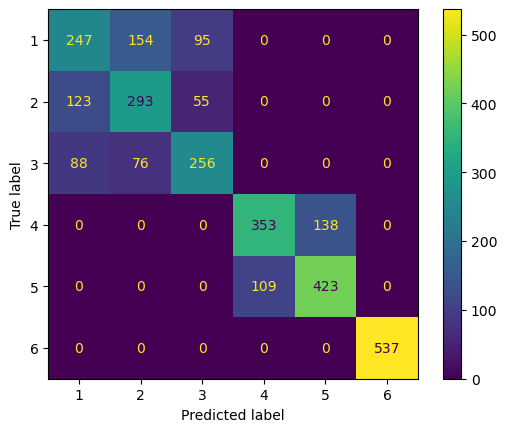

In [12]:
# Mariz de confusão 
accuracy_test = best_tree.score(X=X_test, y=y_test)

print(f'Acurácia da melhor árvore na base de testes: {accuracy_test * 100:.2f}')

confusao_matrix = ConfusionMatrixDisplay.from_estimator(estimator=best_tree, X=X_test, y=y_test);

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [13]:
y_new = clf.predict(X_test)

# Obter a matriz de confusão
CM = confusion_matrix(y_true=y_test, y_pred=y_new)
print("Matriz de Confusão:")
CM

Matriz de Confusão:


array([[242, 153, 101,   0,   0,   0],
       [131, 286,  54,   0,   0,   0],
       [ 86,  79, 255,   0,   0,   0],
       [  0,   0,   0, 353, 138,   0],
       [  0,   0,   0, 109, 423,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)

In [14]:
# Inicializar a lista de acertos
acertos = []

# Iterar sobre a matriz para pegar os elementos da diagonal principal
for x in range(CM.shape[0]):
    acertos.append(CM[x, x])

# Converter a lista de acertos em uma soma
soma_acertos = sum(acertos)

# Calcular a soma total da matriz
soma_total = CM.sum()

# Calcular os erros
erros = soma_total - soma_acertos

# Criar o índice
#indice = pd.Index(data=list(range(1, CM.shape[0] + 1)), name='classe')
indice = pd.Index(data=list(range(1, 7)), name='classe')

# Criar o DataFrame
dados = {
    'acertos': acertos,
    'erros': [erros] * CM.shape[0]  # Ajustar para que cada classe tenha o mesmo número de erros
}

tab = pd.DataFrame(data=dados, index=indice)

# Ordenar o DataFrame pela coluna 'erros' em ordem decrescente
tab_ordenado = tab.sort_values(by='erros', ascending=False)

print("Tabela de acertos e erros por classe:")
tab_ordenado


Tabela de acertos e erros por classe:


,acertos,erros
classe,,
1,242,851
2,286,851
3,255,851
4,353,851
5,423,851
6,537,851


In [15]:
# Classe com maior erro
classe_maior_erro = tab_ordenado.index[0]
print(f"Classe com maior erro: {classe_maior_erro}")

# Criar a variável binária no conjunto de dados de treino
y_erro = (y_train == classe_maior_erro).astype(int)
y_erro.name = "CLASSE_MAIOR_ERRO"

# Treinar o modelo com a nova variável de erro
clf_simple = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=42)
clf_simple.fit(X_train, y_erro)

# Importância das variáveis
importances = clf_simple.feature_importances_
importances_df = pd.DataFrame(importances, index=X_train.columns, columns=['importância'])
importances_df = importances_df.sort_values(by='importância', ascending=False)
print("Importância das variáveis:")
importances_df

Classe com maior erro: 1
Importância das variáveis:


,importância
"('fBodyAcc-mad()-X',)",0.695076
"('tGravityAcc-min()-X',)",0.276908
"('angle(Y,gravityMean)',)",0.028017


In [16]:
# Criar uma variável binária para a classe com maior erro (classe 2 neste caso)
y_train_bin = (y_train == classe_maior_erro).astype(int)
y_test_bin = (y_test == classe_maior_erro).astype(int)

# Treinar o modelo com a nova variável binária
clf_bin = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=42)
clf_bin.fit(X_train, y_train_bin)

# Prever no conjunto de teste
y_pred_bin = clf_bin.predict(X_test)

# Observar a importância das variáveis
importances = clf_bin.feature_importances_
feature_names = X_train.columns
features_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Selecionar as 3 variáveis mais importantes
top_features = features_importance.sort_values(by='importance', ascending=False).head(3)
print(top_features)

# Selecionar as 3 variáveis mais importantes
selected_features = top_features['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Treinar o modelo novamente com as 3 variáveis mais importantes
clf_selected = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=42)
clf_selected.fit(X_train_selected, y_train_bin)

# Prever no conjunto de teste
y_pred_selected = clf_selected.predict(X_test_selected)

# Avaliar o modelo
accuracy_selected = accuracy_score(y_test_bin, y_pred_selected)
report_selected = classification_report(y_test_bin, y_pred_selected)

print(f"Accuracy: {accuracy_selected}")
print("Classification Report:")
print(report_selected)
print('X_train: \n', X_train_selected.columns)
print('X_test: \n', X_test_selected.columns)

                     feature  importance
1      ('fBodyAcc-mad()-X',)    0.695076
0   ('tGravityAcc-min()-X',)    0.276908
2  ('angle(Y,gravityMean)',)    0.028017
Accuracy: 0.8388191381065491
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2451
           1       0.52      0.53      0.52       496

    accuracy                           0.84      2947
   macro avg       0.71      0.71      0.71      2947
weighted avg       0.84      0.84      0.84      2947

X_train: 
 Index(['('fBodyAcc-mad()-X',)', '('tGravityAcc-min()-X',)',
       '('angle(Y,gravityMean)',)'],
      dtype='object')
X_test: 
 Index(['('fBodyAcc-mad()-X',)', '('tGravityAcc-min()-X',)',
       '('angle(Y,gravityMean)',)'],
      dtype='object')


In [17]:
%%time

clf_selected = DecisionTreeClassifier(random_state=42)
path_2 = clf_selected.cost_complexity_pruning_path(X=X_train_selected, 
                                            y=y_train)
ccp_alphas_2, impurities_2 = path_2.ccp_alphas, path_2.impurities
ccp_alphas_2 = np.unique(ccp_alphas_2[ccp_alphas_2 >= 0])

clf_selected = DecisionTreeClassifier(random_state=42)
grid_2 = GridSearchCV(estimator=clf_selected, 
                      param_grid={'ccp_alpha': ccp_alphas_2[::10]}, 
                      cv=10, 
                      verbose=1)
grid_2.fit(X_train_selected, y_train)

resultados_2 = pd.DataFrame(grid_2.cv_results_)
resultados_2.sort_values(by='rank_test_score')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
CPU times: total: 2.34 s
Wall time: 7.12 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
13,0.029128,0.000747,0.003202,0.000458,0.000469,{'ccp_alpha': 0.00046861236333488776},0.898551,0.902174,0.887681,0.896739,0.896552,0.894737,0.898367,0.894737,0.887477,0.909256,0.896627,0.006065,1
12,0.028999,0.000773,0.003012,0.000450,0.000414,{'ccp_alpha': 0.0004137049725303793},0.893116,0.896739,0.884058,0.894928,0.901996,0.898367,0.907441,0.898367,0.883848,0.905626,0.896448,0.007543,2
14,0.028545,0.000537,0.002855,0.000502,0.000548,{'ccp_alpha': 0.0005480997864022891},0.903986,0.898551,0.884058,0.896739,0.892922,0.901996,0.894737,0.892922,0.889292,0.905626,0.896083,0.006384,3
11,0.028699,0.000599,0.003152,0.000393,0.000371,{'ccp_alpha': 0.00037143215870092907},0.893116,0.896739,0.880435,0.894928,0.900181,0.901996,0.907441,0.900181,0.880218,0.901996,0.895723,0.008593,4
10,0.028729,0.000607,0.003254,0.000464,0.000341,{'ccp_alpha': 0.00034149141874930777},0.893116,0.902174,0.876812,0.894928,0.898367,0.901996,0.909256,0.898367,0.878403,0.901996,0.895541,0.009910,5
15,0.028067,0.000419,0.002955,0.000418,0.00061,{'ccp_alpha': 0.0006095595050981335},0.903986,0.887681,0.884058,0.896739,0.896552,0.901996,0.894737,0.887477,0.887477,0.905626,0.894633,0.007302,6
8,0.028950,0.000453,0.002947,0.000416,0.0003,{'ccp_alpha': 0.0003000384049158291},0.896739,0.902174,0.876812,0.896739,0.892922,0.891107,0.911071,0.900181,0.874773,0.901996,0.894451,0.010714,7
7,0.028844,0.000648,0.002934,0.000507,0.000264,{'ccp_alpha': 0.00026433013055300716},0.902174,0.900362,0.878623,0.896739,0.892922,0.896552,0.909256,0.896552,0.872958,0.898367,0.894450,0.010286,8
9,0.029236,0.000510,0.002848,0.000325,0.000324,{'ccp_alpha': 0.00032385097673454555},0.894928,0.902174,0.875000,0.898551,0.900181,0.896552,0.907441,0.896552,0.874773,0.894737,0.894089,0.010254,9
6,0.028838,0.000789,0.003146,0.000227,0.000245,{'ccp_alpha': 0.0002448313384113167},0.902174,0.896739,0.880435,0.896739,0.894737,0.894737,0.911071,0.889292,0.872958,0.898367,0.893725,0.010206,10


In [18]:
melhor_ccp_2 = grid_2.best_params_['ccp_alpha']

print('\n rank_test_score vencedor:')
print('\t mean_test_score:', grid_2.best_score_)
print('\t param_ccp_alpha:', melhor_ccp_2)


 rank_test_score vencedor:
	 mean_test_score: 0.8966270154396485
	 param_ccp_alpha: 0.00046861236333488776


Parâmetro                    Valor
ccp_alpha                 0.000469
class_weight                  None
criterion                     gini
max_depth                     None
max_features                  None
max_leaf_nodes                None
min_impurity_decrease          0.0
min_samples_leaf                 1
min_samples_split                2
min_weight_fraction_leaf       0.0
random_state                    42
splitter                      best 

Acurácia da árvore na base de testes: 0.7156430268069223


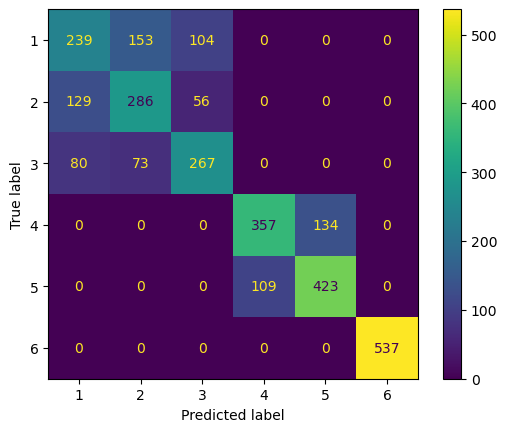

CPU times: total: 93.8 ms
Wall time: 224 ms


In [19]:
%%time

clf_selected = DecisionTreeClassifier(random_state=42, 
                               ccp_alpha=melhor_ccp_2
                              ).fit(X_train_selected, y_train)
print(pd.DataFrame(data=clf_selected.get_params(), 
                   index=pd.Index(data=['Valor'], 
                                  name='Parâmetro')
                  ).T, 
      '\n')

print('Acurácia da árvore na base de testes:', 
      clf_selected.score(X=X_test_selected, y=y_test))

ConfusionMatrixDisplay.from_estimator(estimator=clf_selected, 
                                      X=X_test_selected, 
                                      y=y_test)
plt.show()